<a href="https://colab.research.google.com/github/MacUpr/ML/blob/main/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Impotando as Bibliotecas

In [49]:
import tensorflow as tf
# Instalando o KerasTuner.
!pip install keras-tuner --upgrade
from tensorflow.keras import datasets, layers, models
# Bibliotecas Auxiliares
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Importanda a biblioteca KerasTuner.
import keras_tuner as kt
import torch
from torchvision import transforms
from PIL import Image
import cv2
from sklearn.metrics import confusion_matrix
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

##Baixando e normalizando os dados.

O conjunto de dados CIFAR10 contém 60.000 imagens coloridas em 10 classes, com 6.000 imagens em cada classe. O conjunto de dados é dividido em 50.000 imagens de treinamento e 10.000 imagens de teste. As classes são mutuamente exclusivas e não há sobreposição entre elas.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 2s 0us/step


##Verifique os dados

Para verificar se o conjunto de dados parece correto, vamos plotar as primeiras 20 imagens do conjunto de treinamento e exibir o nome da classe abaixo de cada imagem:

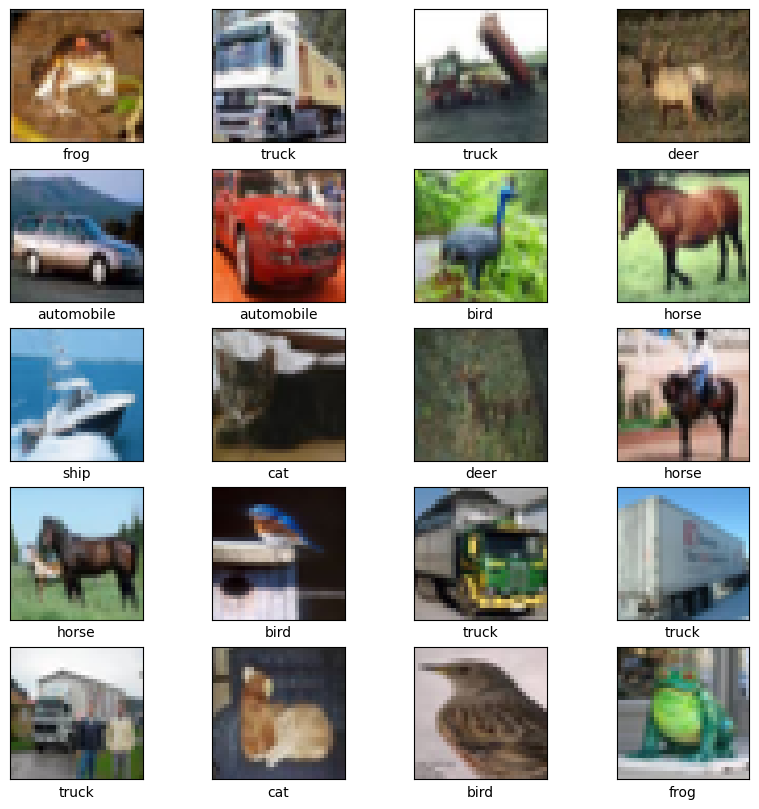

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

##Otimização hiperparamétrica

In [ ]:
def build_model(hp):

    # Cria o modelo sequêncial.
    model = tf.keras.Sequential()

    # Number of convolutional layers.
    numOfConvLayers = hp.Choice('numOfConvLayers', range(1, 11))

    # Seleciona o número de camadas densas.
    numOfDenseLayers = hp.Choice('numOfDenseLayers', range(0, 3))

    # Número inicial de nós nas camadas densas.
    numberOfNodes = hp.Choice('numberOfNodes', [1024, 512, 256, 128, 64])

    # Seleciona o tmanho dos filtros.
    filterSize = hp.Choice('filterSize', [8, 16, 32, 64])

    # Seleciona a função de ativação.
    activation = hp.Choice('activation', ['relu', 'tanh'])

    # Seleciona o otimizador.
    optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'nadam'])

    # Seleciona o kernel size.
    kernelSize = hp.Choice('kernelSize', [2, 4, 6])

    # Adiciona camadas convolucionais.
    for i in range(numOfConvLayers):
        if(i==0):
            model.add(tf.keras.layers.Conv2D(filters=filterSize, kernel_size=kernelSize, activation=activation, padding='same', input_shape=(32, 32, 3)))
        else:
            model.add(tf.keras.layers.Conv2D(filters=filterSize*(i+1), kernel_size=kernelSize, activation=activation, padding='same'))
        if(i % 2 != 0):
            model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Adiciona camada de achatamento.
    model.add(tf.keras.layers.Flatten())

    # Adiciona camadas densas.
    for i in range(numOfDenseLayers):
        model.add(tf.keras.layers.Dense(units=numberOfNodes//(i+1), activation=activation, kernel_initializer='he_uniform'))

    # Adiciona a camada de saída.
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

    # Compile the defined model.
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Retorna o modelo.
    return model

###Usando otimização bayesiana para encontrar os melhores hiperparâmetros.

A otimização bayesiana é uma técnica empregada na otimização de hiperparâmetros, especialmente na escolha dos melhores parâmetros para modelos de aprendizado de máquina. No contexto do Keras Tuner, ela é uma estratégia de busca disponível para encontrar os hiperparâmetros mais eficazes.

Essa abordagem opera de maneira eficiente no espaço de hiperparâmetros por meio de um processo probabilístico. Em vez de testar todas as combinações possíveis de hiperparâmetros, o método mantém uma distribuição de probabilidade das funções objetivas, como a precisão do modelo. Essa distribuição é então utilizada para determinar quais configurações de hiperparâmetros devem ser avaliadas a seguir.

A otimização bayesiana busca equilibrar a exploração (experimentação de diferentes configurações de hiperparâmetros) e a exploração (foco nas configurações com maior probabilidade de resultar em melhor desempenho). À medida que mais avaliações de modelos são realizadas, a distribuição de probabilidade é atualizada, refinando progressivamente a busca em direção às configurações de hiperparâmetros mais promissoras.

In [ ]:
# Instanciando um objeto da classe BayesianOptimization.
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20
)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

tuner.search(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    batch_size=64,
    epochs=10,
    callbacks=[stop_early]
)

Trial 20 Complete [00h 01m 13s]
val_loss: 1.7293541431427002

Best val_loss So Far: 0.6901487112045288
Total elapsed time: 01h 47m 43s


In [ ]:
best_model = tuner.get_best_models(1)[0]

best_model.build(input_shape=(32,32))

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       32896     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 192)       98496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       196864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                   

##Avaliando o modelo

Epoch 1/10
782/782 [==============================] - 20s 24ms/step - loss: 0.4743 - accuracy: 0.8375 - val_loss: 0.9296 - val_accuracy: 0.7189
Epoch 2/10
782/782 [==============================] - 18s 24ms/step - loss: 0.3710 - accuracy: 0.8720 - val_loss: 0.9261 - val_accuracy: 0.7302
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2952 - accuracy: 0.8975 - val_loss: 1.1582 - val_accuracy: 0.6906
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 0.2359 - accuracy: 0.9180 - val_loss: 1.0089 - val_accuracy: 0.7584
Epoch 5/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1865 - accuracy: 0.9358 - val_loss: 1.0371 - val_accuracy: 0.7750
Epoch 6/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1523 - accuracy: 0.9463 - val_loss: 1.6045 - val_accuracy: 0.7090
Epoch 7/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1285 - accuracy: 0.9554 - val_loss: 1.3587 - val_accuracy:

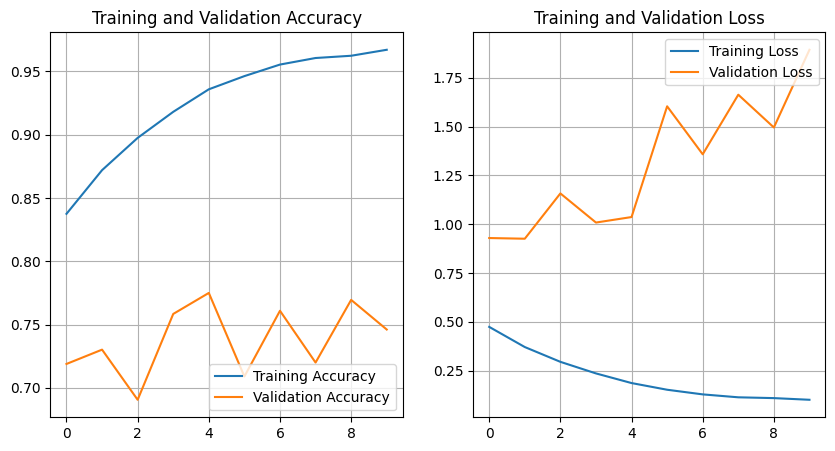

In [ ]:

# Recompile the model
best_model.compile(loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Fit the model
history = best_model.fit(train_images, train_labels,
                         validation_data=(test_images, test_labels),
                         batch_size=64,
                         epochs=10,
                         callbacks=[stop_early])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()

##Transfer learning

In [45]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)
# Modify the last fully connected layer to match the number of classes in CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Send the model to the GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {100 * accuracy:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Loss: 0.8980863980581878
Epoch 2/5, Loss: 0.6204992148140952
Epoch 3/5, Loss: 0.5599021633523287
Epoch 4/5, Loss: 0.5253469613467129
Epoch 5/5, Loss: 0.4895888911375463
Test Accuracy: 94.23%


## maTRIZ CONF

Test Accuracy: 93.56%


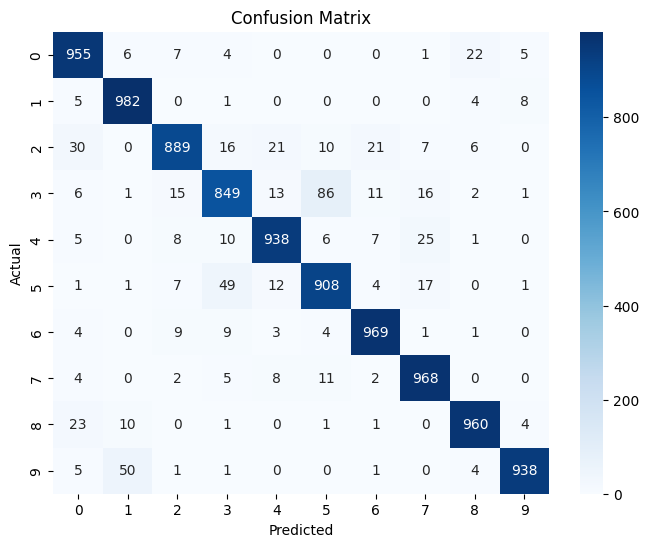

In [ ]:


# Evaluation
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {100 * accuracy:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
class_names = [str(i) for i in range(10)]  # assuming 10 classes in CIFAR-10
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Eval REal

ls: cannot access 'content': No such file or directory
Predicted class: dog
Predicted class: airplane
Predicted class: automobile
Predicted class: bird
Predicted class: frog
Predicted class: horse
Predicted class: deer
Predicted class: ship
Predicted class: truck
Predicted class: cat


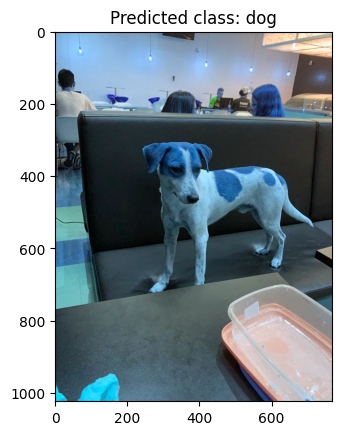

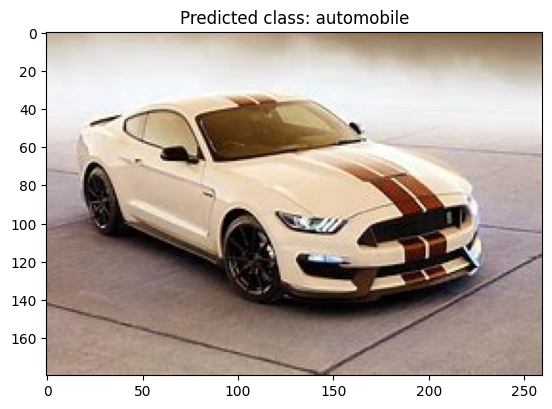

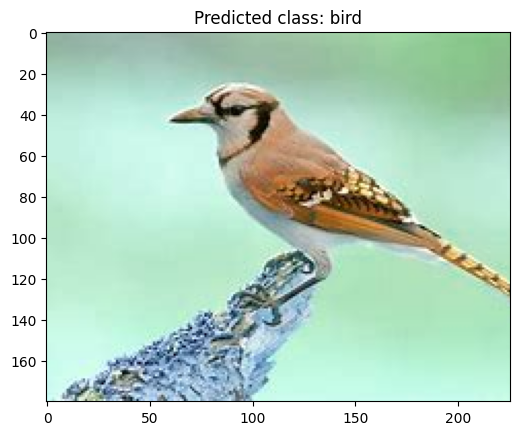

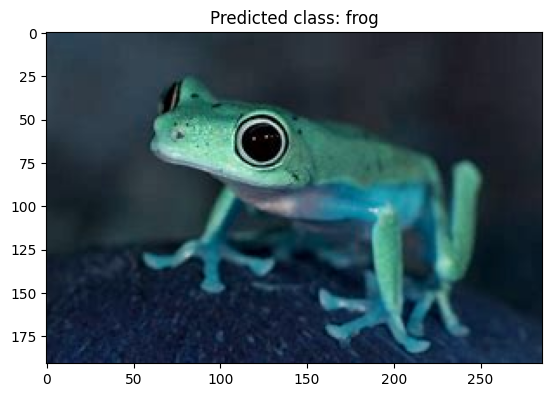

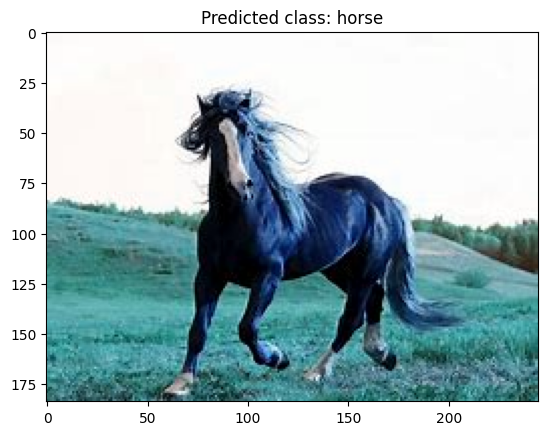

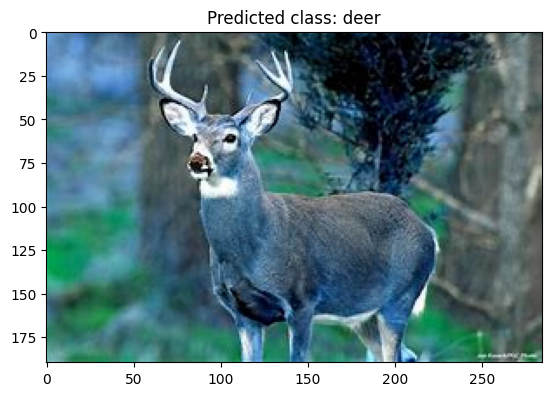

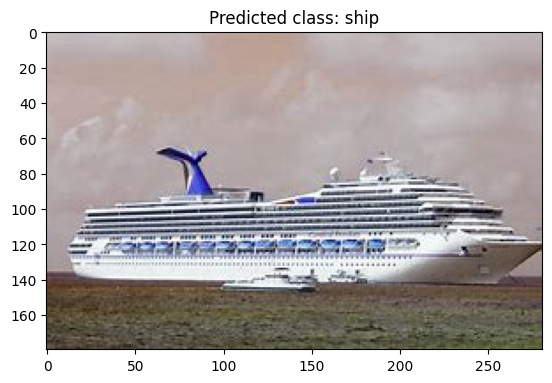

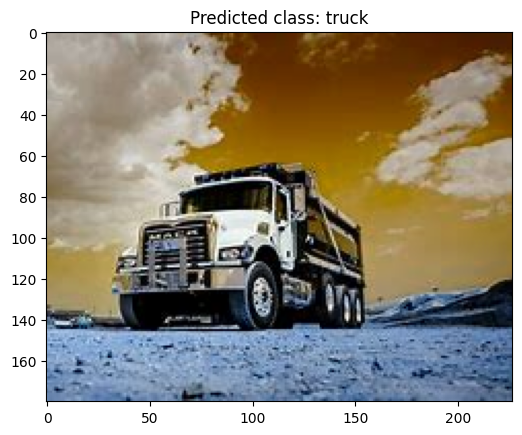

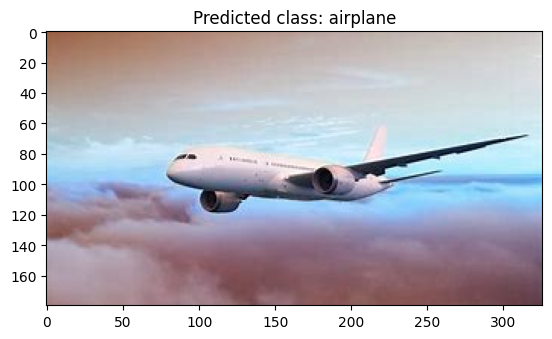

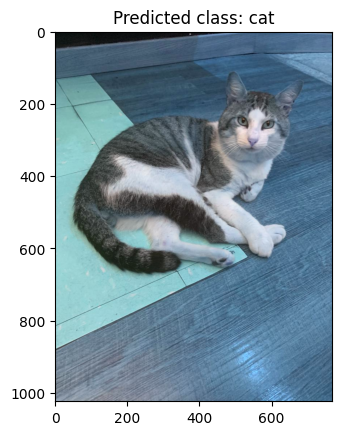

In [52]:


# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# permitir acesso a carpeta dos imagenes baixadas
!ls content
# Load the images
img_path = "/content/WhatsApp Image 2023-11-22 at 18.54.52.jpeg"
img = Image.open(img_path)

img1_path = "/content/airplane.jpg"
img1 = Image.open(img1_path)

img2_path = "/content/auto.jpg"
img2 = Image.open(img2_path)

img3_path = "/content/bird.jpg"
img3 = Image.open(img3_path)

img4_path = "/content/frog.jpg"
img4 = Image.open(img4_path)

img5_path = "/content/horse.jpg"
img5 = Image.open(img5_path)

img6_path = "/content/deer.jpg"
img6 = Image.open(img6_path)

img7_path = "/content/ship.jpg"
img7 = Image.open(img7_path)

img8_path = "/content/truck.jpg"
img8 = Image.open(img8_path)

img9_path = "/content/dog1.jpeg"
img9 = Image.open(img9_path)

# Apply the transformations
img = transform(img)
img1 = transform(img1)
img2 = transform(img2)
img3 = transform(img3)
img4 = transform(img4)
img5 = transform(img5)
img6 = transform(img6)
img7 = transform(img7)
img8 = transform(img8)
img9 = transform(img9)
# Add batch dimension to the image
img = img.unsqueeze(0)
img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)
img3 = img3.unsqueeze(0)
img4 = img4.unsqueeze(0)
img5 = img5.unsqueeze(0)
img6 = img6.unsqueeze(0)
img7 = img7.unsqueeze(0)
img8 = img8.unsqueeze(0)
img9 = img9.unsqueeze(0)

# Send the image to the same device as the model
img = img.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
img3 = img3.to(device)
img4 = img4.to(device)
img4 = img4.to(device)
img5 = img5.to(device)
img6 = img6.to(device)
img7 = img7.to(device)
img8 = img8.to(device)
img9 = img9.to(device)



# Set the model to evaluation mode
model.eval()

# Make the prediction
with torch.no_grad():
    output = model(img)
    output1 = model(img1)
    output2 = model(img2)
    output3 = model(img3)
    output4 = model(img4)
    output5 = model(img5)
    output6 = model(img6)
    output7 = model(img7)
    output8 = model(img8)
    output9 = model(img9)


# Get the predicted class
_, predicted_class = torch.max(output, 1)
_, predicted_class1 = torch.max(output1, 1)
_, predicted_class2 = torch.max(output2, 1)
_, predicted_class3 = torch.max(output3, 1)
_, predicted_class4 = torch.max(output4, 1)
_, predicted_class5 = torch.max(output5, 1)
_, predicted_class6 = torch.max(output6, 1)
_, predicted_class7 = torch.max(output7, 1)
_, predicted_class8 = torch.max(output8, 1)
_, predicted_class9 = torch.max(output9, 1)

# Load CIFAR-10 class labels
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]



# Print the predicted class label
print("Predicted class:", cifar10_labels[predicted_class.item()])
print("Predicted class:", cifar10_labels[predicted_class1.item()])
print("Predicted class:", cifar10_labels[predicted_class2.item()])
print("Predicted class:", cifar10_labels[predicted_class3.item()])
print("Predicted class:", cifar10_labels[predicted_class4.item()])
print("Predicted class:", cifar10_labels[predicted_class5.item()])
print("Predicted class:", cifar10_labels[predicted_class6.item()])
print("Predicted class:", cifar10_labels[predicted_class7.item()])
print("Predicted class:", cifar10_labels[predicted_class8.item()])
print("Predicted class:", cifar10_labels[predicted_class9.item()])

# Show the original image
img = cv2.imread(img_path)
plt.imshow(img)
plt.title("Predicted class: " + cifar10_labels[predicted_class.item()])
plt.show()

img2 = cv2.imread(img2_path)
plt.imshow(img2)
plt.title("Predicted class: " + cifar10_labels[predicted_class2.item()])
plt.show()

img3 = cv2.imread(img3_path)
plt.imshow(img3)
plt.title("Predicted class: " + cifar10_labels[predicted_class3.item()])
plt.show()

img4 = cv2.imread(img4_path)
plt.imshow(img4)
plt.title("Predicted class: " + cifar10_labels[predicted_class4.item()])
plt.show()

img5 = cv2.imread(img5_path)
plt.imshow(img5)
plt.title("Predicted class: " + cifar10_labels[predicted_class5.item()])
plt.show()

img6 = cv2.imread(img6_path)
plt.imshow(img6)
plt.title("Predicted class: " + cifar10_labels[predicted_class6.item()])
plt.show()

img7 = cv2.imread(img7_path)
plt.imshow(img7)
plt.title("Predicted class: " + cifar10_labels[predicted_class7.item()])
plt.show()

img8 = cv2.imread(img8_path)
plt.imshow(img8)
plt.title("Predicted class: " + cifar10_labels[predicted_class8.item()])
plt.show()

img1 = cv2.imread(img1_path)
plt.imshow(img1)
plt.title("Predicted class: " + cifar10_labels[predicted_class1.item()])
plt.show()

img9 = cv2.imread(img9_path)
plt.imshow(img9)
plt.title("Predicted class: " + cifar10_labels[predicted_class9.item()])
plt.show()

